<a href="https://colab.research.google.com/github/renatog17/tcc_reconhecimento_emocoes_fala/blob/main/tcc_youtube_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display as ld
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

#Definindo função para extrair dados dos áudios

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def extrair_informacoes_arquivo(nome_arquivo, ignorar_extra=False):
    partes = nome_arquivo.split('-')
    
    # Remover o conteúdo entre parênteses no final do nome do arquivo
    partes[3] = partes[3].split('(')[0]
    
    # Remover a extensão .mp3 no final do nome do arquivo
    if partes[-1].lower().endswith(".mp3"):
        partes[-1] = partes[-1][:-4]
    
    emocao = int(partes[0])
    nome_jogo = int(partes[1])
    genero_jogo = int(partes[2])
    voz_interlocutor = int(partes[3])
    
    # Ignorar qualquer coisa além dos quatro primeiros parâmetros, se desejado
    if ignorar_extra:
        partes = partes[:4]
    
    # Resto do código permanece igual
    emocao_descricao = {
        1: "Calmo",
        2: "Raiva",
        3: "Feliz"
    }
    
    nome_jogo_descricao = {
        1: "League of Legends",
        2: "Dota 2",
        3: "Dead Island 2",
        4: "Day Z",
        5: "Pubg",
        6: "Fifa",
        7: "Poker Star",
        8: "Fall Guys",
        9: "Fortinite",
        10: "Hogwarts Legacy",
        11: "Zelda Tears of The Kingdom",
        12: "Yakuza 4",
        13: "Valorant",
        14: "Elden Ring"
    }
    
    genero_jogo_descricao = {
        1: "MOBA",
        2: "Shooter",
        3: "Blattle Royale",
        4: "Esporte",
        5: "Ação e Aventura",
         6: "Apostas",
        7: "Campeonato",
        8: "Party Game",
        9: "Zumbi",
        10: "Mundo Aberto",
        11: "Souls Like"
    }
    
    genero_interlocutor_descricao = {
        1: "Masculino",
        2: "Feminino"
    }
    
    emocao_desc = emocao_descricao.get(emocao, "Emoção Desconhecida")
    nome_jogo_desc = nome_jogo_descricao.get(nome_jogo, "Jogo Desconhecido")
    genero_jogo_desc = genero_jogo_descricao.get(genero_jogo, "Gênero Desconhecido")
    genero_interlocutor_desc = genero_interlocutor_descricao.get(voz_interlocutor, "Gênero do Interlocutor Desconhecido")
    
    return emocao_desc, nome_jogo_desc, genero_jogo_desc, genero_interlocutor_desc




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Criação do csv

In [ ]:
import os
import csv

def percorrer_pastas_e_criar_csv(caminho_pasta):
    # Abrir o arquivo CSV para escrita
    with open('informacoes_audios.csv', 'w', newline='') as arquivo_csv:
        escritor_csv = csv.writer(arquivo_csv)
        # Escrever o cabeçalho do CSV
        escritor_csv.writerow(['emocao', 'nome do jogo', 'genero do jogo', 'genero do interlocutor', 'path'])
        
        # Percorrer as pastas audios1 e audios2
        for pasta_principal in ['caio', 'jose']:
            caminho_pasta_principal = os.path.join(caminho_pasta, pasta_principal)
            
            # Percorrer as pastas calmo, feliz e raiva
            for pasta_emocao in ['calmo', 'feliz', 'raiva']:
                caminho_pasta_emocao = os.path.join(caminho_pasta_principal, pasta_emocao)
                
                # Percorrer os arquivos de áudio
                for nome_arquivo in os.listdir(caminho_pasta_emocao):
                    caminho_arquivo = os.path.join(caminho_pasta_emocao, nome_arquivo)
                    
                    # Extrair as informações do arquivo
                    emocao, nome_jogo, genero_jogo, genero_interlocutor = extrair_informacoes_arquivo(nome_arquivo)
                    
                    # Escrever as informações no arquivo CSV
                    escritor_csv.writerow([emocao, nome_jogo, genero_jogo, genero_interlocutor, caminho_arquivo])
                    
    print("Arquivo CSV criado com sucesso!")

# Chamar a função para percorrer as pastas e criar o arquivo CSV
percorrer_pastas_e_criar_csv('/content/drive/MyDrive/yotube_audios/youtube_audios')

FileNotFoundError: ignored

In [ ]:
df = pd.read_csv('informacoes_audios.csv')
df
df.emocao.value_counts()

Series([], Name: emocao, dtype: int64)

In [ ]:
audio = df.loc[10]
data, sample_rate = librosa.load(audio.path, sr=None)

KeyError: ignored

In [ ]:
ld.waveshow(y = data, sr=sample_rate)
print('Número total de amostras: ', data.shape[0])
print('Taxa de amostragem: ', sample_rate)
print('Duração', len(data)/sample_rate)

#Extração do coeficiente mfcc

In [ ]:
from tqdm import tqdm
def features_extractor(file_name): 
    data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(df.path.values):
  data = features_extractor(path)
  extracted_features.append([data])

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])
extracted_features_df

In [ ]:
X = np.array(extracted_features_df['feature'].tolist()) #características
y = np.array(df.emocao.tolist()) #emoçoes
X.shape
y.shape

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
labelencoder.classes_

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify= shuffle=)
#150 áudios no total
#30% validação e teste, 50% para validação e 50% para teste
#70% treinamento
#105 áudios para treinamento, 21 para validação e depois de tudo 24 para teste final

In [ ]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape, X_test.shape

#Treinamento da rede neural

In [ ]:
input_shape=(X_train.shape[1],1)
input_shape

(40, 1)

In [ ]:
num_labels = y.shape[1]
num_labels

3

In [ ]:
model=Sequential()

model.add(Conv1D(64, kernel_size=(5), activation='relu',input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(256, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 36, 64)            384       
                                                                 
 conv1d_7 (Conv1D)           (None, 36, 128)           41088     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 7, 128)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 7, 256)            164096    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 256)           

In [ ]:
num_epochs = 50
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/content/saved_models/speech'
    +'_emotion_recognition.hdf5', 
    verbose=1, save_best_only=True)                               
model_history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, 
                          validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 3.8067 - accuracy: 0.3388
Epoch 1: val_loss improved from inf to 5.92319, saving model to /content/saved_models/speech_emotion_recognition.hdf5
2/2 [==============================] - 2s 491ms/step - loss: 3.8067 - accuracy: 0.3388 - val_loss: 5.9232 - val_accuracy: 0.2903
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 4.0707 - accuracy: 0.4711
Epoch 2: val_loss improved from 5.92319 to 1.80734, saving model to /content/saved_models/speech_emotion_recognition.hdf5
2/2 [==============================] - 0s 191ms/step - loss: 4.0707 - accuracy: 0.4711 - val_loss: 1.8073 - val_accuracy: 0.4839
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 2.7700 - accuracy: 0.3967
Epoch 3: val_loss improved from 1.80734 to 1.70577, saving model to /content/saved_models/speech_emotion_recognition.hdf5
2/2 [==============================] - 0s 165ms/step - loss: 2.7700 - accuracy: 0.3967 - val_loss: 1.705

In [ ]:
model.evaluate(X_test,Y_test, verbose=0)

[0.13585136830806732, 0.9354838728904724]

In [ ]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


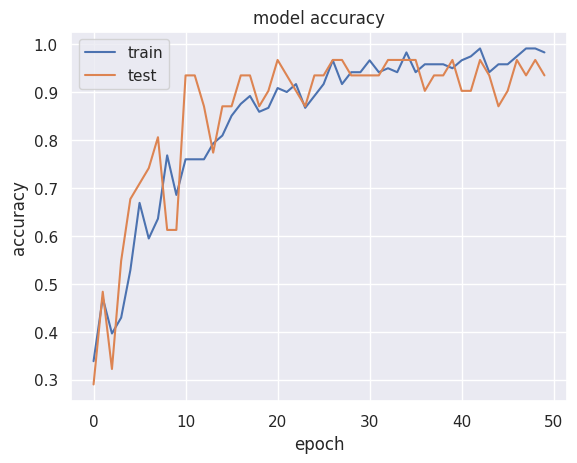

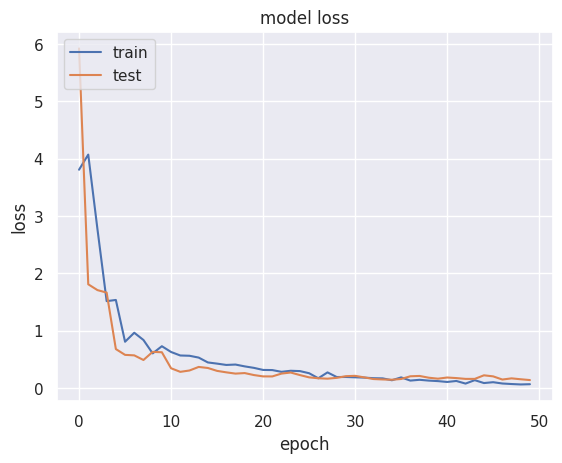

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)

1/1 [==============================] - 0s 112ms/step


In [ ]:
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})

In [ ]:
actual = Y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (labelencoder.inverse_transform((actual)))
actual = pd.DataFrame({'Classes Reais': actual})

In [ ]:
finaldf = actual.join(predictions)
finaldf[100:150]

,Classes Reais,Classes Previstas


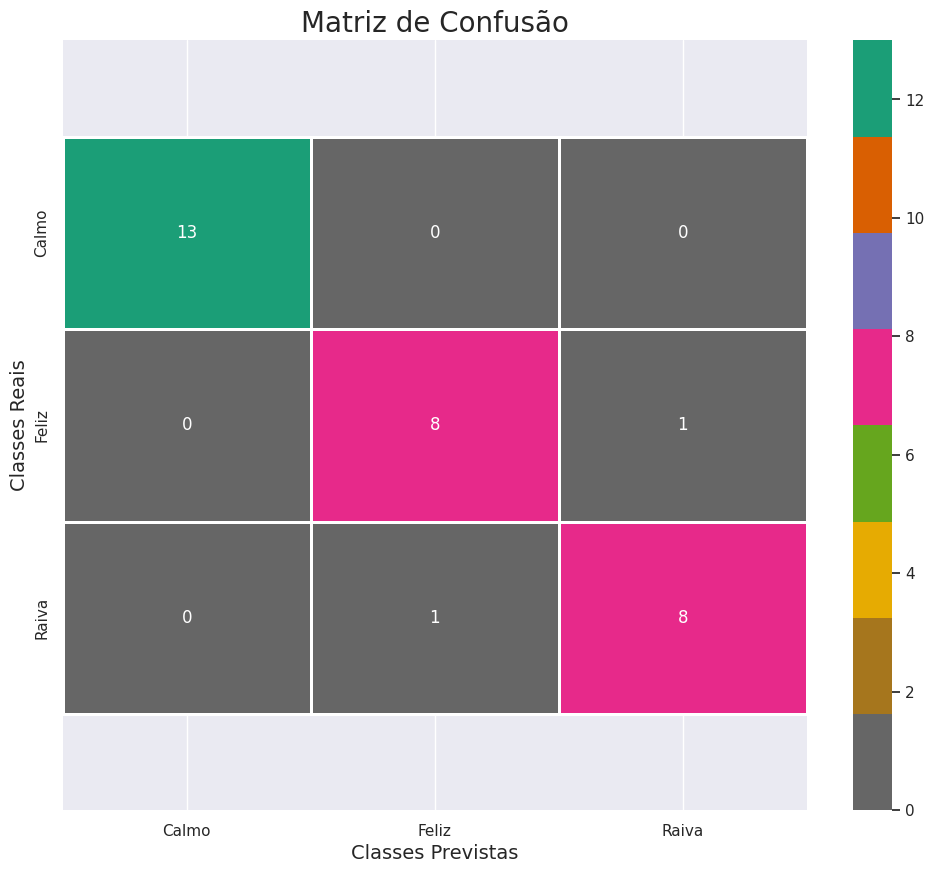

In [ ]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

In [ ]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       Calmo       1.00      1.00      1.00        13
       Feliz       0.89      0.89      0.89         9
       Raiva       0.89      0.89      0.89         9

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31



#Testando com áudio

In [ ]:
def getInfo(data, sample_rate):  
  print('Canais: ', data.shape)
  print('Número total de amostras: ', data.shape[0])
  print('Taxa de amostragem: ', sample_rate)
  print('Duração: ',  len(data) / sample_rate)  

def predictSound(AUDIO, info = False, plot_waveform = False, plot_spectrogram = False):
  audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast') 
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]
  predictions = model.predict(mfccs_scaled_features)
  plt.barh(labelencoder.classes_, predictions[0], color=list('rgbkymc'))
  predictions = predictions.argmax(axis=1)
  predictions = predictions.astype(int).flatten()
  predictions = (labelencoder.inverse_transform((predictions)))
  print('Resultado:', predictions) 

  if info:
    getInfo(audio, sample_rate)    

  if plot_waveform:
    plt.figure(figsize=(14,5))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    plt.xlabel("Tempo (segundos) ==>")
    plt.ylabel("Amplitude") 
    ld.waveshow(audio, sr=sample_rate)
  
  if plot_spectrogram:
    plt.figure(figsize=(14,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs_features))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    ld.specshow(mfccs_db, x_axis="time", y_axis='log', cmap = 'Spectral')
    plt.colorbar(format='%+2.f dB')  

In [ ]:
AUDIO = "/content/drive/MyDrive/yotube_audios/youtube_audios/caio/feliz/03-01-01-01(4).mp3"
audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
Audio(data = audio, rate = sample_rate)

1/1 [==============================] - 0s 34ms/step
Resultado: ['Feliz']
Canais:  (320394,)
Número total de amostras:  320394
Taxa de amostragem:  44100
Duração:  7.265170068027211


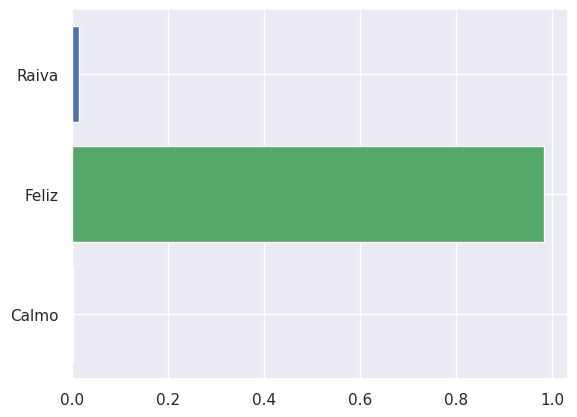

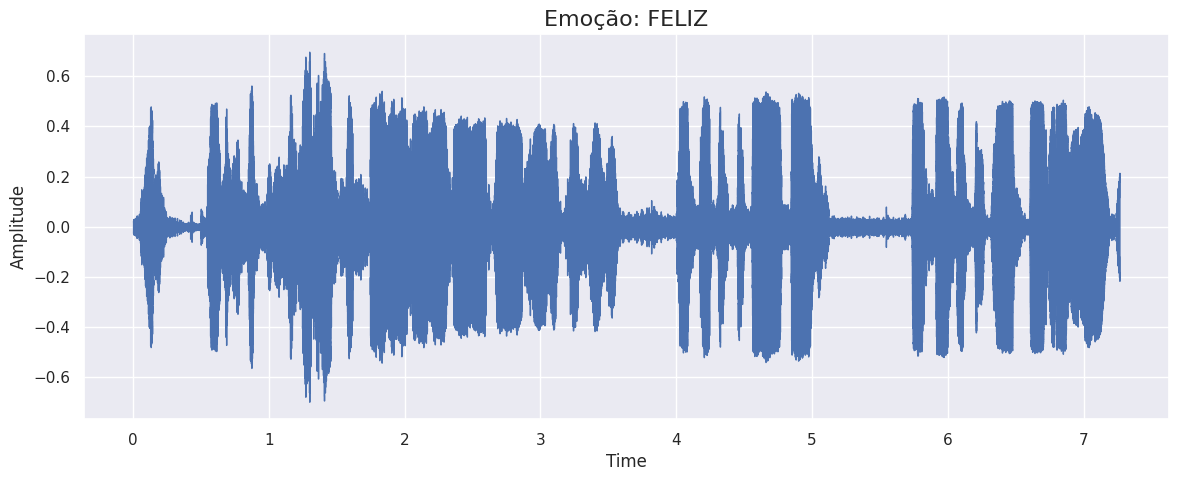

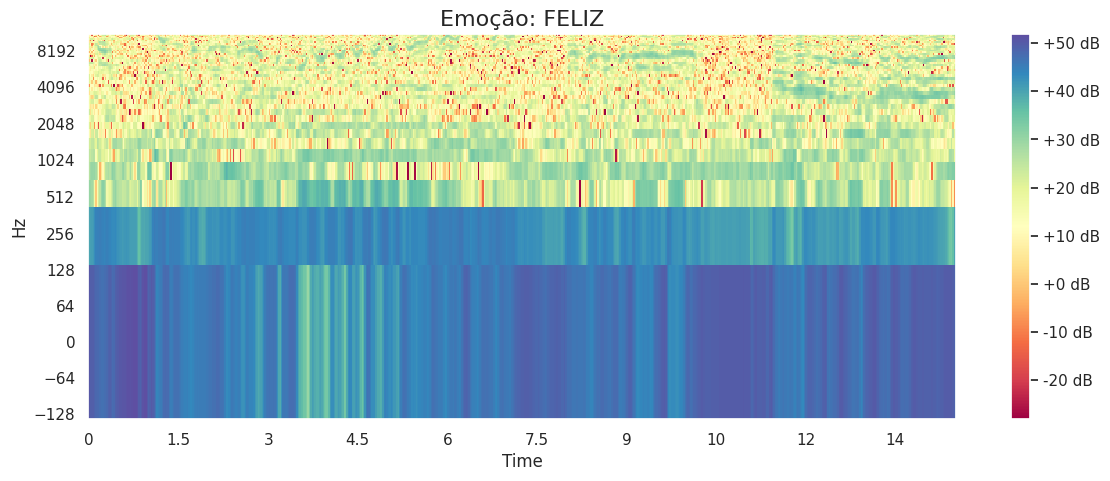

In [ ]:
predictSound(AUDIO, info = True, plot_waveform = True, plot_spectrogram = True)